### Mindmap

In [4]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from pydantic import BaseModel, Field

In [5]:
load_dotenv()

True

In [6]:
# Structured output for model for quiz output

from typing import List


class QuestionOptions(BaseModel):
    A: str = Field("Option A for the question")
    B: str = Field("Option B for the question")
    C: str = Field("Option C for the question")
    D: str = Field("Option D for the question")


class Question(BaseModel):
    question: str = Field(
        description="Question")
    options: QuestionOptions
    correctAnswer: str = Field(description="Correct answer - one of these options A, B, C or D")
    hint: str = Field(
        description="A small hint to help user think in right direction")
    explaination: str = Field(description="Explaination of the correct answer")
    

class QuizOutput(BaseModel):
    title: str = Field(description="A suitable title for the quiz.")
    questions: List[Question] = Field(
        description="A list of quiz questions in MCQ format, with each question having 4 options."
    )

In [7]:
# output structures
class SummaryNoteOutput(BaseModel):
    title: str = Field(description="Title of the note")
    summary: str = Field(description="Summary Note in markdown language")    

In [13]:
from typing import Dict, Optional


class GraphAttributes(BaseModel):
    rankdir: str = "TB"
    bgcolor: str = "lightgray"
    node: Dict[str, str] = {
        "shape": "ellipse",
        "style": "filled",
        "fillcolor": "white",
        "fontname": "Arial",
        "fontsize": "12"
    }
    edge: Dict[str, str] = {
        "fontname": "Arial",
        "fontsize": "10"
    }


class Node(BaseModel):
    id: str
    label: str
    fillcolor: Optional[str] = "white"


class Edge(BaseModel):
    source: str
    target: str
    label: Optional[str] = None


class MindMapStructure(BaseModel):
    # graph_attributes: GraphAttributes
    nodes: List[Node]
    edges: List[Edge]
    central_node: str

In [14]:
# Student profile type definition
from typing import Optional, TypedDict


class StudentProfile(TypedDict):
    gender: str
    class_level: str  # e.g., "class 6", "12th", "undergrad", "postgrad"
    language: str     # e.g., "hindi", "english", "marathi"


class UserPrompt(TypedDict):
    topic: str
    file_url: Optional[str]
# Graph state


class State(TypedDict):
    learning_space_id: str
    student_profile: StudentProfile
    user_prompt: UserPrompt
    summary_notes: SummaryNoteOutput
    podcast_script: str
    mindmap: MindMapStructure
    quiz: QuizOutput
    recommended_resources: str
    study_plan: str
    combined_output: str

In [4]:
model = init_chat_model("gemini-2.0-flash", model_provider="google_genai", )
response = model.invoke("Hello World!!")
print(response)

content='Hello there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--ea6e2e2e-a19a-41ea-9855-f4c1e3bcd065-0' usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}}


In [15]:
# Agent Node - Notes Summary

def node_mindmap(state: State):
    """LLM call to generate quiz based on summary content"""

    # generate the chat prompt

    """Create a personalized prompt based on student profile"""

    prompt_template = ChatPromptTemplate([
        ("system", """ 
        You are a helpful academic tutor.
        Use the below context to create a json response to create a mind map using graph viz in python. The mind map should clearly explain the core concepts and key ideas.
        
        Student Profile:
            - Class Level: {grade_level}
            - Language: {language} 
            - Gender: {gender}
         
        1. Adapt your language and complexity based on the student's profile provided.
        2. Respond in JSON format which can be used to render.
        """),
        ("user", "Topic Summary {topic_summary}")
    ])
    
   
    # init a new model with structured output
    model = init_chat_model(
        "gemini-2.0-flash", model_provider="google_genai").with_structured_output(MindMapStructure)

    chain = prompt_template | model
    
    response = chain.invoke(
        {
            "grade_level": state['student_profile'].get("grade_level", "general"),
            "language": state['student_profile'].get("language", "English"),
            "gender": state['student_profile'].get("gender", ""),
            "topic_summary": state["summary_notes"]
        }
    )

    # # update in supabase database
    # supabase_response = (
    #     supabase.table("learning_space")
    #     .update({"summary_notes": response.model_dump()})
    #     .eq("id", state["learning_space_id"])
    #     .execute()
    # )

    # print("Supabase Response", supabase_response)

    return {"mindmap": response.model_dump()}

In [16]:
input_state = {
    "learning_space_id": '48484754-ae7c-4b4b-bdea-12784ed54a2f',
    "student_profile": {
        "gender": "MALE",
        "grade_level": "12th",
        "language": "HINDI"
    },
    "user_prompt": {
        "topic": "Uncertainty in AI",
        "file_url": "https://kclenjtsvdayeghmmmkm.supabase.co/storage/v1/object/public/learning-sources/public/Slides_Module8.pdf",
    },
    "summary_notes": """
    {"title": "AI में अनिश्चितता (Uncertainty in AI) ", "summary": "# AI में अनिश्चितता (Uncertainty in AI) पर नोट्स\n\n## मॉड्यूल का उद्देश्य:\n*   AI सिस्टम्स में ज्ञान और तर्क में अनिश्चितता को मापने और प्रबंधित करने के तरीकों को समझना और लागू करना।\n\n## विषय:\n*   **अनिश्चितता में काम करना (Acting under Uncertainty):**\n    *   एजेंट्स को अनिश्चितता से निपटने की आवश्यकता हो सकती है।\n    *   एक एजेंट को निश्चित रूप से पता नहीं हो सकता कि वह किस स्थिति में है या कार्यों के क्रम के बाद वह कहां समाप्त होगा।\n    *   एजेंट्स को एक विश्वास स्थिति (belief state) का ट्रैक रखकर अनिश्चितता को संभालने के लिए डिज़ाइन किया गया है।\n    *   उदाहरण: एक स्वचालित टैक्सी का लक्ष्य है कि वह एक यात्री को समय पर हवाई अड्डे पर पहुंचाए।\n\n*   **अनिश्चितता का सारांश (Summarizing uncertainty):**\n    *   अनिश्चित तर्क का एक उदाहरण देखते हैं।\n    *   निदान (Diagnosis) - चाहे चिकित्सा, ऑटोमोबाइल की मरम्मत, या कुछ भी हो - लगभग हमेशा अनिश्चितता शामिल होती है।\n    *   प्रस्तावात्मक तर्क (propositional logic) का उपयोग करके दंत निदान (dental diagnosis) के लिए नियम लिखने का प्रयास करते हैं।\n    *   एक साधारण नियम पर विचार करें:\n        *   दांत दर्द (Toothache) → कैविटी (Cavity)\n        *   दांत दर्द (Toothache) → कैविटी (Cavity) या मसूड़ों की समस्या (GumProblem) या फोड़ा (Abscess) ...\n        *   कैविटी (Cavity) → दांत दर्द (Toothache)\n    *   चिकित्सा निदान जैसे डोमेन से निपटने के लिए तर्क का उपयोग करने का प्रयास तीन मुख्य कारणों से विफल रहता है:\n        *   आलस्य (Laziness)\n        *   सैद्धांतिक अज्ञानता (Theoretical ignorance)\n        *   व्यावहारिक अज्ञानता (Practical ignorance)\n    *   एजेंट का ज्ञान सबसे अच्छा संबंधित वाक्यों में विश्वास की डिग्री प्रदान कर सकता है।\n    *   विश्वास की डिग्री से निपटने के लिए हमारा मुख्य उपकरण प्रायिकता सिद्धांत (probability theory) है।\n    *   प्रायिकता हमारी आलस्य और अज्ञानता से आने वाली अनिश्चितता को सारांशित करने का एक तरीका प्रदान करती है।\n    *   एक भ्रमित करने वाला बिंदु यह है कि निदान के समय, वास्तविक दुनिया में कोई अनिश्चितता नहीं है: रोगी को या तो कैविटी है या नहीं।\n\n*   **अनिश्चितता और तर्कसंगत निर्णय (Uncertainty and rational decisions):**\n    *   सफलता दरों (Success Rates) की तुलना।\n    *   विश्वसनीयता (Reliability) का महत्व।\n    *   ट्रेड-ऑफ और असुविधाएं (Trade-offs and Inconveniences)।\n    *   प्राथमिकताएं और परिणाम (Preferences and Outcomes)।\n    *   उपयोगिता सिद्धांत (Utility Theory)।\n    *   उपयोगिता की सापेक्षता (Relativity of utility)।\n        *   एजेंट परिप्रेक्ष्य (agent perspective) के आधार पर उपयोगिता की व्यक्तिपरकता (Subjectivity)।\n        *   उपयोगिता कार्यों में विविध प्राथमिकताओं का समायोजन (Accommodation)।\n    *   प्रायिकता और उपयोगिता सिद्धांतों का एकीकरण (Integration)।\n    *   अधिकतम अपेक्षित उपयोगिता (Maximum Expected Utility (MEU)) का सिद्धांत।\n    *   विभिन्न डोमेन में अनुप्रयोग (Application)।\n\n*   **बुनियादी प्रायिकता संकेतन (Basic Probability Notation):**\n    *   स्पष्टता और परिशुद्धता (Clarity and Precision):\n        *   असंदिग्ध संचार (Unambiguous communication)।\n        *   औपचारिक प्रतिनिधित्व (Formal representation)।\n    *   उन्नत विश्लेषण (Advanced Analysis) के लिए आधार:\n        *   जटिल मॉडल के लिए बिल्डिंग ब्लॉक (Building block)।\n        *   गणना और एल्गोरिदम (calculations and algorithms) को सुविधाजनक बनाना।\n\n*   **प्रायिकताएं किसके बारे में हैं (What probabilities are about):**\n    *   नमूना स्थान (Sample space)।\n    *   प्रायिकता मॉडल (Probability model)।\n    *   घटनाएँ (Events)।\n    *   बिना शर्त और पूर्व प्रायिकता (Unconditional and Prior probability)।\n    *   साक्ष्य (Evidence)।\n    *   सशर्त और उत्तर प्रायिकता (Conditional and Posterior probability)।\n    *   उत्पाद नियम (Product rule)।\n\n*   **प्रायिकता अभिकथन (probability assertions) में प्रस्तावों की भाषा (language):**\n    *   यादृच्छिक चर (Random variables)।\n    *   डोमेन (Domain)।\n    *   प्रायिकता वितरण (Probability distribution)।\n    *   प्रायिकता घनत्व फलन (Probability density function)।\n    *   संयुक्त प्रायिकता वितरण (Joint probability distribution)।\n    *   पूर्ण संयुक्त प्रायिकता वितरण (Full joint probability distribution)।\n\n*   **प्रायिकता स्वयंसिद्ध (Probability axioms) और उनकी तर्कसंगतता (reasonableness):**\n    *   प्रायिकता स्वयंसिद्ध उन मूलभूत सिद्धांतों का निर्माण करते हैं जिन पर प्रायिकता का पूरा सिद्धांत बना है।\n        *   गैर-नकारात्मकता स्वयंसिद्ध (Non-negativity Axiom)।\n        *   सामान्यीकरण स्वयंसिद्ध (Normalization Axiom)।\n    *   प्रायिकता स्वयंसिद्धों की तर्कसंगतता (Reasonableness):\n        *   तार्किक स्थिरता (Logical Consistency)।\n        *   सहज ज्ञान युक्त अपील (Intuitive Appeal)।\n        *   गणितीय आधार (Mathematical Foundation)।\n        *   अनुप्रयोग (Applicability)।\n    *   समावेश-बहिष्करण सिद्धांत (Inclusion-exclusion principle)।\n\n*   **पूर्ण संयुक्त वितरण (Full Joint Distributions) का उपयोग करके अनुमान (Inference):**\n    *   संभाव्य अनुमान (Probabilistic inference) अनिश्चितता के तहत तर्क और निर्णय लेने की प्रक्रिया है, जो प्रायिकता सिद्धांत (probability theory) से सिद्धांतों का उपयोग करके मान्यताओं को अपडेट करती है या भविष्यवाणियां करती है।\n    *   अनुमान के प्रकार (Type of inference):\n        *   सीमांतीकरण (Marginalization)।\n        *   सशर्त प्रायिकता (Conditional Probability)।\n        *   संयुक्त अनुमान (Joint Inference)।\n    *   संभाव्य अनुमान (Probabilistic inference) की प्रक्रिया:\n        *   समस्या को परिभाषित करें (Define)।\n        *   एक मॉडल का निर्माण करें (Construct)।\n        *   अनुमान (Inference)।\n        *   परिणामों का मूल्यांकन और व्याख्या करें (Evaluate and Interpret)।\n\n*   **स्वतंत्रता (Independence):**\n    *   मान लीजिए कि हम दांत दर्द, कैच, कैविटी की दुनिया के लिए पूर्ण संयुक्त वितरण का विस्तार एक चौथे बाइनरी चर, मौसम (Weather) (W) को जोड़कर करते हैं।\n    *   चार बाइनरी चर के साथ, इन चर के 16 संभावित संयोजन हैं।\n    *   तालिका की प्रत्येक पंक्ति चर T, C, H, और W के एक अद्वितीय संयोजन का प्रतिनिधित्व करती है।\n    *   अंतिम कॉलम घटनाओं के उस विशिष्ट संयोजन की प्रायिकता का प्रतिनिधित्व करता है।\n    *   सीमांत प्रायिकताएँ (Marginal Probabilities)।\n        *   T = True (दांत दर्द) की सीमांत प्रायिकता (Marginal probability):\n        *   W = Sunny (मौसम धूप है) की सीमांत प्रायिकता (Marginal probability):\n    *   उदाहरण के लिए, P(toothache, catch, cavity, cloudy) और P(toothache, catch, cavity) कैसे संबंधित हैं?\n    *   इससे, हम अनुमान लगा सकते हैं,\n    *   वास्तव में, हम सामान्य समीकरण लिख सकते हैं\n    *   इस प्रकार, चार चर के लिए 32-तत्व तालिका को एक 8-तत्व तालिका और एक 4-तत्व तालिका से बनाया जा सकता है।\n    *   पूर्ण स्वतंत्रता का उपयोग करके बड़े संयुक्त वितरण को छोटे वितरणों में फैक्टर करने के उदाहरण।\n    *   स्वतंत्रता के प्रकार (Types):\n        *   सीमांत स्वतंत्रता (Marginal independence)।\n            *   अन्य चर पर कंडीशनिंग के बिना, अलग-अलग माने जाने वाले व्यक्तिगत चर की स्वतंत्रता।\n        *   पूर्ण स्वतंत्रता (Absolute independence)।\n            *   चर की स्वतंत्रता तब भी होती है जब किसी अन्य चर पर कंडीशनिंग की जाती है।\n\n*   **बेयस का नियम (Bayes' Rule) और इसका उपयोग (Use):**\n    *   उत्पाद नियम (product rule) को इस प्रकार लिखा जा सकता है:\n    *   इस समीकरण को बेयस का नियम (Bayes' rule) (जिसे बेयस का कानून या बेयस का प्रमेय भी कहा जाता है) के रूप में जाना जाता है। यह सरल समीकरण संभाव्य अनुमान (probabilistic inference) के लिए अधिकांश आधुनिक AI प्रणालियों को रेखांकित करता है।\n    *   बेयस का नियम संभाव्य अनुमान (probabilistic inference) के लिए मौलिक है और कई आधुनिक AI प्रणालियों को रेखांकित करता है।\n    *   उदाहरण स्पैम फ़िल्टरिंग (Example Spam Filtering)।\n        *   P(H|E): साक्ष्य E दिए जाने पर परिकल्पना H की उत्तर प्रायिकता (Posterior probability)।\n        *   P(E|H): यदि H सत्य है तो साक्ष्य E को देखने की संभावना।\n        *   P(H): परिकल्पना H की पूर्व प्रायिकता (Prior probability)।\n        *   P(E): साक्ष्य E को देखने की सीमांत प्रायिकता (Marginal probability)।\n    *   चिकित्सा निदान (Medical Diagnosis)।"}...
    """
}

In [17]:
response = node_mindmap(input_state)

In [18]:
response['mindmap']

{'nodes': [{'id': 'AI में अनिश्चितता',
   'label': 'AI में अनिश्चितता',
   'fillcolor': '#ADD8E6'},
  {'id': 'अनिश्चितता में काम करना',
   'label': 'अनिश्चितता में काम करना',
   'fillcolor': '#E6B8AF'},
  {'id': 'अनिश्चितता का सारांश',
   'label': 'अनिश्चितता का सारांश',
   'fillcolor': '#E6B8AF'},
  {'id': 'अनिश्चितता और तर्कसंगत निर्णय',
   'label': 'अनिश्चितता और तर्कसंगत निर्णय',
   'fillcolor': '#E6B8AF'},
  {'id': 'बुनियादी प्रायिकता संकेतन',
   'label': 'बुनियादी प्रायिकता संकेतन',
   'fillcolor': '#E6B8AF'},
  {'id': 'प्रायिकताएं किसके बारे में हैं',
   'label': 'प्रायिकताएं किसके बारे में हैं',
   'fillcolor': '#E6B8AF'},
  {'id': 'प्रायिकता अभिकथन में प्रस्तावों की भाषा',
   'label': 'प्रायिकता अभिकथन में प्रस्तावों की भाषा',
   'fillcolor': '#E6B8AF'},
  {'id': 'प्रायिकता स्वयंसिद्ध और उनकी तर्कसंगतता',
   'label': 'प्रायिकता स्वयंसिद्ध और उनकी तर्कसंगतता',
   'fillcolor': '#E6B8AF'},
  {'id': 'पूर्ण संयुक्त वितरण का उपयोग करके अनुमान',
   'label': 'पूर्ण संयुक्त वितरण का उप

In [19]:
import graphviz

In [20]:
dot = graphviz.Digraph(comment='The round table')

In [24]:
nodes = response['mindmap']['nodes']
edges = response['mindmap']['edges']

In [23]:
for node in nodes:
    dot.node(node['id'], node['label'], shape="ellipse",
             style='filled', fillcolor='#90EE90')

In [25]:
for edge in edges:
    dot.edge(edge['source'], edge['target'])

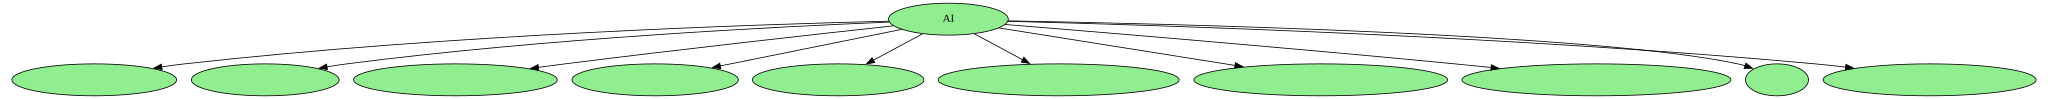

In [26]:
dot

In [27]:
with open('mindmap.png', 'wb') as f:
    f.write(dot.pipe(format='png'))

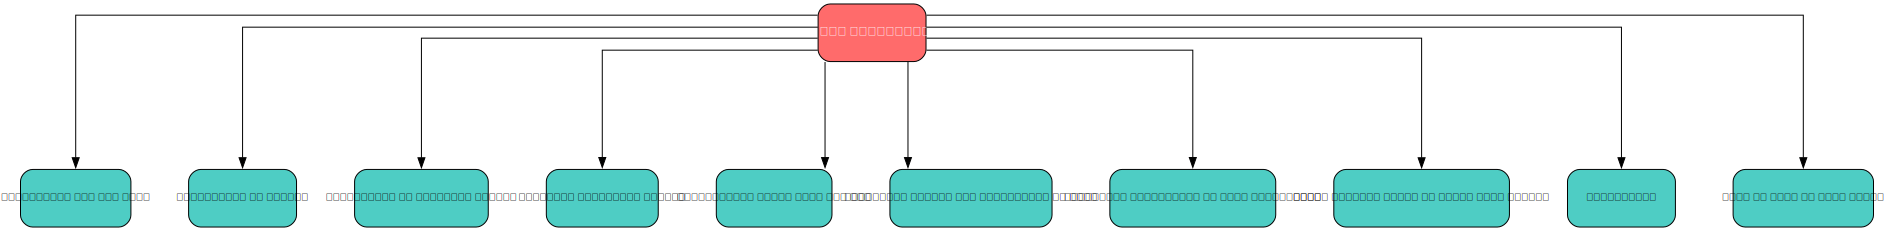

In [28]:
def create_balanced_mindmap(mindmap_data):
    """Create a more balanced mindmap layout"""

    dot = graphviz.Digraph(comment='Educational Mindmap')

    # Set graph attributes for better layout
    dot.attr(
        rankdir='TB',  # Top to Bottom
        ranksep='1.5',  # Increase vertical separation
        nodesep='0.8',  # Increase horizontal separation
        splines='ortho',  # Use orthogonal edges
        bgcolor='white'
    )

    # Node styling
    dot.attr('node',
             shape='box',
             style='rounded,filled',
             fontname='Arial',
             fontsize='10',
             width='1.5',
             height='0.8'
             )

    nodes = mindmap_data['nodes']
    edges = mindmap_data['edges']
    central_node = mindmap_data.get('central_node', '')

    # Group nodes by their level (distance from central node)
    node_levels = {}
    for edge in edges:
        if edge['source'] == central_node:
            node_levels[edge['target']] = 1
        elif edge['source'] in node_levels:
            node_levels[edge['target']] = node_levels[edge['source']] + 1

    # Add central node
    dot.node(central_node,
             next(node['label']
                  for node in nodes if node['id'] == central_node),
             fillcolor='#FF6B6B', fontcolor='white', fontsize='12')

    # Add level 1 nodes (main concepts) in subgraphs
    level1_nodes = [node for node in nodes if node['id']
                    in node_levels and node_levels[node['id']] == 1]

    # Create subgraphs for better clustering
    for i, node in enumerate(level1_nodes):
        with dot.subgraph(name=f'cluster_{i}') as cluster:
            cluster.attr(style='invisible')  # Make cluster invisible
            cluster.node(node['id'], node['label'],
                         fillcolor='#4ECDC4', fontcolor='black')

    # Add remaining nodes
    for node in nodes:
        if node['id'] != central_node and node['id'] not in [n['id'] for n in level1_nodes]:
            dot.node(node['id'], node['label'],
                     fillcolor='#96CEB4', fontcolor='black')

    # Add edges
    for edge in edges:
        dot.edge(edge['source'], edge['target'])

    return dot


# Use the balanced layout
balanced_dot = create_balanced_mindmap(response['mindmap'])
balanced_dot

In [ ]:
import io
from datetime import datetime


def upload_mindmap_to_supabase(dot_graph, learning_space_id: str, bucket_name: str = "mindmaps"):
    """Upload mindmap image to Supabase Storage"""

    try:
        # Generate image bytes
        image_bytes = dot_graph.pipe(format='png')

        # Create filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"mindmap_{learning_space_id}_{timestamp}.png"

        # Upload to Supabase Storage
        response = supabase.storage.from_(bucket_name).upload(
            path=filename,
            file=image_bytes,
            file_options={
                "content-type": "image/png",
                "upsert": True  # Overwrite if exists
            }
        )

        if response.error:
            print(f"❌ Upload error: {response.error}")
            return None

        # Get public URL
        public_url = supabase.storage.from_(
            bucket_name).get_public_url(filename)

        print(f"✅ Mindmap uploaded successfully: {filename}")
        return {
            "filename": filename,
            "public_url": public_url,
            "storage_path": f"{bucket_name}/{filename}"
        }

    except Exception as e:
        print(f"❌ Error uploading mindmap: {str(e)}")
        return None